In [1]:
import pandas as pd
import numpy as np
from apyori import apriori
import random
from tqdm import tqdm
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [2]:
#pip install python-Levenshtein

In [3]:
df=pd.read_excel('Online Retails.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df=df.dropna()
df.shape

(406829, 8)

# Data Preparation

In [6]:
df['StockCode']=df['StockCode'].astype(str)

In [7]:
#checking the number of unique customers in the dataset
customers=df['CustomerID'].unique().tolist()
len(customers)

4372

In [8]:
# spliting the data into train and validation datasets

#shuffling Customer IDs
random.shuffle(customers)


In [9]:
# taking 90% of data from customers IDs
customers_train=[customers[i] for i in range(round(0.9*len(customers)))]

#split data into train and validation set
df_train=df[df['CustomerID'].isin(customers_train)]
df_validation=df[~df['CustomerID'].isin(customers_train)]

In [10]:
print(df_validation.shape)
print(df_train.shape)

(38566, 8)
(368263, 8)


In [11]:
# list to capute purchase history of the customers for training set
purchases_train=[]

# populate the list with the product codes
for i in tqdm(customers_train):
    temp=df_train[df_train['CustomerID']==i]['StockCode'].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:05<00:00, 686.99it/s]


In [12]:
# list to capute purchase history of the customers for validation set
purchases_val=[]

# populate the list with the product codes
for i in tqdm(df_validation['CustomerID'].unique()):
    temp=df_validation[df_validation['CustomerID']==i]['StockCode'].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 849.03it/s]


# Build word2vec Embeddings for Products

In [13]:
# train word2vec model
model=Word2Vec(window=10, sg=1, hs=0, negative=10, alpha=0.03, min_alpha=0.0007, seed=14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples=model.corpus_count, epochs=10, report_delay=1)

(3646104, 3682630)

In [14]:
# calling init_sims() will make the model much more memory-efficient
model.init_sims(replace=True)

In [15]:
print(model)

Word2Vec(vocab=3172, size=100, alpha=0.03)


In [16]:
# Extract all vectors
import gensim
X=model[model.wv.vocab]





array([[ 0.06213529,  0.03037665, -0.09976508, ...,  0.13064826,
         0.0719662 , -0.04229552],
       [ 0.03265589, -0.00309391, -0.12653711, ...,  0.11193381,
         0.06965651, -0.13366634],
       [ 0.08415558, -0.04669452, -0.1810448 , ...,  0.24865186,
         0.11255943, -0.1657468 ],
       ...,
       [-0.05488974,  0.00498078,  0.10219105, ...,  0.01517881,
        -0.12366404, -0.02952631],
       [-0.00831294,  0.04744991,  0.10233504, ...,  0.05242191,
        -0.06785283, -0.04375797],
       [-0.02399383,  0.12522312, -0.10524178, ...,  0.05401263,
         0.13570021, -0.02912091]], dtype=float32)

In [17]:
X.shape

(3172, 100)

# Visualize word2vec Embeddings

In [18]:
#pip install umap-learn

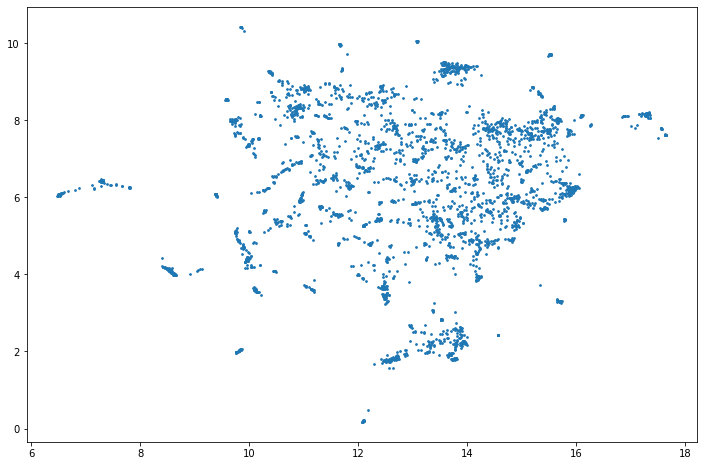

In [19]:
import umap.umap_ as umap
cluster_embedding=umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(12, 8))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

# Recommending Products

In [20]:
products=df_train[['StockCode', 'Description']]

#remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep='last')

#create product-ID and product-discription dictionary
products_dict=products.groupby('StockCode')['Description'].apply(list).to_dict()

In [21]:
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

In [22]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms

In [23]:
similar_products(model['90019A'])

[('SILVER M.O.P ORBIT DROP EARRINGS', 0.8222140073776245),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.817731499671936),
 ('JADE DROP EARRINGS W FILIGREE', 0.7913018465042114),
 ('SILVER LARIAT BLACK STONE EARRINGS', 0.7844226956367493),
 ('BLACK VINTAGE  CRYSTAL EARRINGS', 0.7764742374420166),
 ('WHITE VINT ART DECO CRYSTAL NECKLAC', 0.7756556868553162)]

In [24]:
# let's define a function to recommend products based on the multiple purchases he or she has made in the past
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [25]:
# Recall that we have already created a separate list of purchase sequences for validation purposes. Now let’s make use of that.

aggregate_vectors(purchases_val[0]).shape

(100,)

In [27]:
similar_products(aggregate_vectors(purchases_val[0]))

[('MINI PAINT SET VINTAGE ', 0.7024404406547546),
 ('SET/6 RED SPOTTY PAPER CUPS', 0.7012134790420532),
 ('SET/6 RED SPOTTY PAPER PLATES', 0.6974282264709473),
 ('ROUND SNACK BOXES SET OF 4 FRUITS ', 0.6913471221923828),
 ('RETROSPOT PARTY BAG + STICKER SET', 0.6726714372634888),
 ('RED TOADSTOOL LED NIGHT LIGHT', 0.6725178956985474)]